# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b44273b872d5f265fb04fd93916efbf0079d3d6a97b960454e0d9101e2373a41
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=63ba7226660db0ff32f51f40ddfa6141f50c281f1be2e4d04ef4c009946063ac
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (3/3), done.


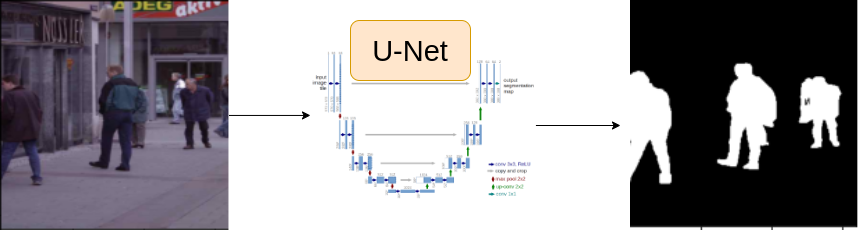

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = 320
EPOCHS = 25
BATCH_SIZE = 16
LR = 0.003
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
image.shape, mask.shape

((183, 276, 3), (183, 276))

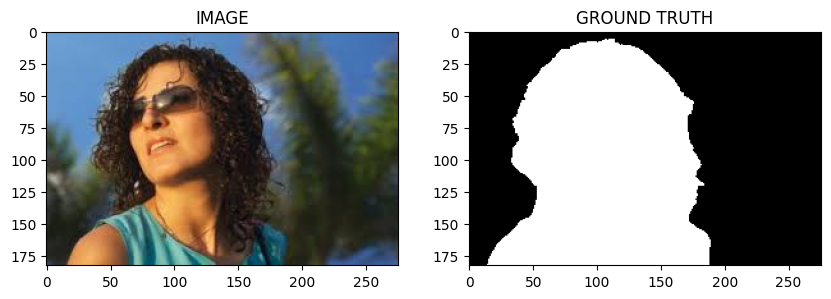

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

      image = np.transpose(image, axes=(2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, axes=(2, 0, 1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask

In [ ]:
trainset = SegmentDataset(train_df, get_train_augs())
validset = SegmentDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


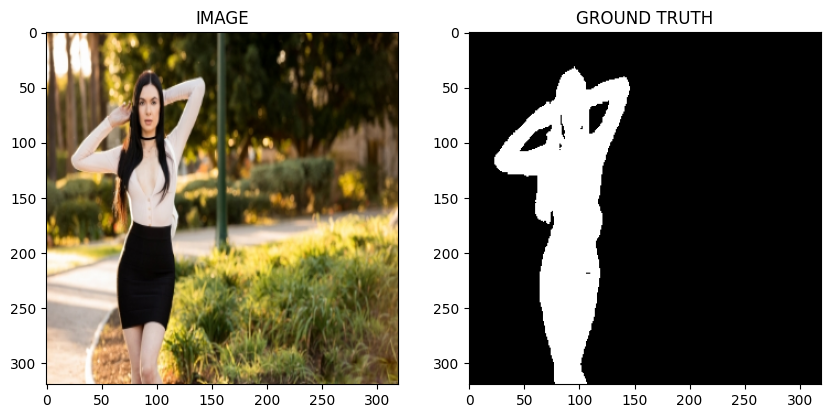

In [ ]:
idx = 120

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
validloader = DataLoader(
    validset,
    batch_size=BATCH_SIZE
)

In [ ]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

NameError: ignored

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  return total_loss / len(dataloader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
  train_loss = train_fn(dataloader=trainloader, model=model, optimizer=optimizer)
  valid_loss = eval_fn(dataloader=validloader, model=model)

  if valid_loss  < train_loss:
    torch.save(model.state_dict(), 'best_model_pt')
    print("MODEL SAVED")
    best_valid_loss = valid_loss

  print(f"Epoch : {epoch+1}   Train_loss : {train_loss}   Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Epoch : 1   Train_loss : 0.7054653803507487   Valid_loss : 0.8333445563912392


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch : 2   Train_loss : 0.3705754816532135   Valid_loss : 0.6923060342669487


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


MODEL SAVED
Epoch : 3   Train_loss : 0.33371657828489937   Valid_loss : 0.24883195385336876


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


MODEL SAVED
Epoch : 4   Train_loss : 0.2546348452568054   Valid_loss : 0.23277321457862854


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


MODEL SAVED
Epoch : 5   Train_loss : 0.21920099457105   Valid_loss : 0.19837868213653564


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch : 6   Train_loss : 0.20129234890143077   Valid_loss : 0.2276528663933277


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


MODEL SAVED
Epoch : 7   Train_loss : 0.19092696011066437   Valid_loss : 0.16544491983950138


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch : 8   Train_loss : 0.19467435081799825   Valid_loss : 0.33125928044319153


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Epoch : 9   Train_loss : 0.2346092075109482   Valid_loss : 0.2537745535373688


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch : 10   Train_loss : 0.21917708218097687   Valid_loss : 0.23237187415361404


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch : 11   Train_loss : 0.1630379522840182   Valid_loss : 0.19884256832301617


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 12   Train_loss : 0.14516293158133825   Valid_loss : 0.20348288863897324


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch : 13   Train_loss : 0.1685314307610194   Valid_loss : 0.2382548674941063


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Epoch : 14   Train_loss : 0.15632122854391733   Valid_loss : 0.1766176037490368


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch : 15   Train_loss : 0.11897906810045242   Valid_loss : 0.17653155326843262


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch : 16   Train_loss : 0.139107413093249   Valid_loss : 0.16472004726529121


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch : 17   Train_loss : 0.10959950139125188   Valid_loss : 0.17148162052035332


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch : 18   Train_loss : 0.11959082285563151   Valid_loss : 0.15286837331950665


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch : 19   Train_loss : 0.12467426657676697   Valid_loss : 0.25193895399570465


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 20   Train_loss : 0.16049586435159047   Valid_loss : 0.20375731959939003


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch : 21   Train_loss : 0.12270477016766866   Valid_loss : 0.19023912400007248


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Epoch : 22   Train_loss : 0.11799619992574056   Valid_loss : 0.1848939210176468


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch : 23   Train_loss : 0.1273486023147901   Valid_loss : 0.18309738859534264


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


Epoch : 24   Train_loss : 0.12031693607568741   Valid_loss : 0.1968332603573799


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

Epoch : 25   Train_loss : 0.12596624741951626   Valid_loss : 0.18953828141093254


# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/best_model_pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

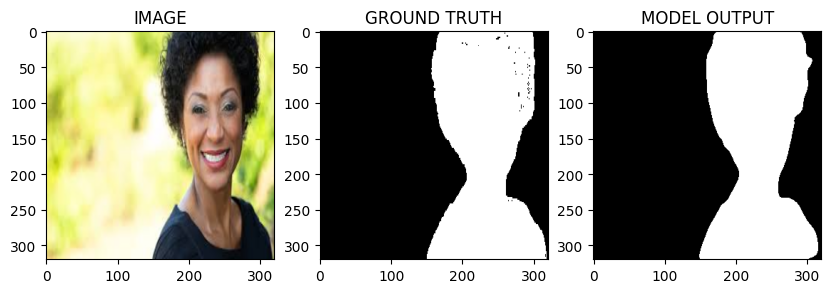

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya